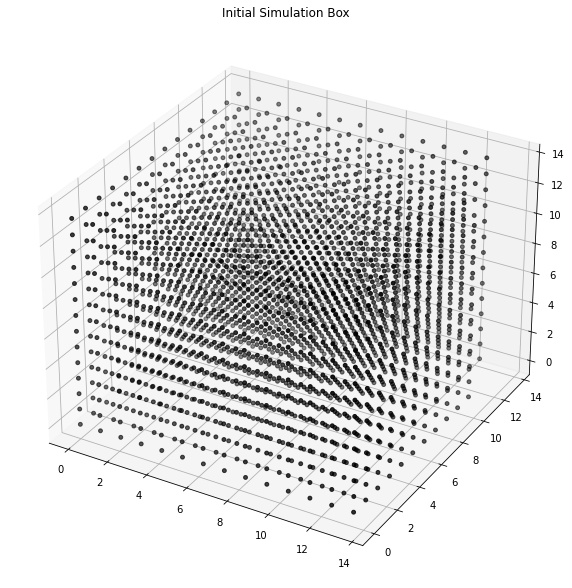

In [1]:
import numpy as np
import random
import math
import matplotlib.pyplot as plt

L = 15
N = 2700
delr = 0.1


oldpositions = np.zeros((N, 3))
rx = np.zeros((N, N))
ry = np.zeros((N, N))
rz = np.zeros((N, N))
r = np.zeros((N, N))

g = np.zeros(N)
gave = np.zeros(N)

np.random.seed(0)  # Seed for reproducibility

# Generate regular initial coordination of atoms in the Cell
cnt = 0
for i in range(14):
    for j in range(14):
        for w in range(14):
            if cnt < N:
                oldpositions[cnt] = np.array([i * 1.04, j * 1.04, w * 1.04])
                cnt += 1

# Plotting the simulation box
fig = plt.figure(figsize=(10,15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(oldpositions[:, 0], oldpositions[:, 1], oldpositions[:, 2], s=15, c='black')
ax.set_title('Initial Simulation Box')
plt.show()

In [2]:
def dcalculation(atom1, atom2, L):
    dx = atom1[0] - atom2[0]
    dy = atom1[1] - atom2[1]
    dz = atom1[2] - atom2[2]

    dx -= L * round(dx / L)
    dy -= L * round(dx / L)
    dz -= L * round(dx / L)
    return math.sqrt(dx**2 + dy**2 + dz**2)


In [3]:
Uinitial = 0
oldUini = np.zeros(N)
rtemporary = 0
Ushift = 4 * (1 / 2.5 ** 12 - 1 / 2.5 ** 6)

# calculate the initial distances of all atoms respect eachother
for i in range(N - 1):
    for j in range(i + 1, N):
        r[i,j] = dcalculation(oldpositions[j], oldpositions[i], L)
        r[j,i] = r[i,j]

        #calculate initial enrgy (shifted, truncated) of the simulaton box
        if r[i,j] <= 2.5:
            Uinitial += (4 * ((1 / r[i,j] ** 12 - 1 / r[i,j] ** 6)) - Ushift)

# Computing the potential energy of each atom
for i in range(N):
    for j in range(N):
        if r[i,j] <= 2.5 and i != j:
            oldUini[i] += ((4 * (1 / r[i,j] ** 12 - 1 / r[i,j] ** 6)) - Ushift)


# Calculate the number of atom at different radius
Radius = np.arange(0.1, 6.1, 0.1)
dr = 0.1
grinit = np.zeros(60)
for i in range(1, 61):
    mask = np.logical_and(r <= i * dr, r > (i - 1) * dr)
    sp = np.sum(np.triu(mask, k=1))
    grinit[i - 1] = sp * 3 * L ** 3 / (2 * np.pi * N * (N - 1) * ((i * dr) ** 3 - ((i - 1) * dr) ** 3))
        
# Plotting RDF
plt.figure(figsize=(8,5))
plt.plot(Radius, grinit)
plt.title('Initial RDF')
plt.xlabel('Radius ($\sigma$)')
plt.ylabel('g(r)')
plt.show()

In [ ]:
# MonteCarlo NVT
accepted = 0
rejected = 0
NaveRDF = 0

Ut = [Uinitial]
oldU = oldUini
nts = 800000
Tr = 1
rdfps = 0
maxdelta = 0.2
newcoord = np.zeros(3)
rt = np.zeros(N)
gr = np.zeros(60)

for step in range(nts):
    #select a random particle
    i = math.floor(random.random() * N)
    #move the particle randomly to a new location
    newcoord = oldpositions[i] + (np.random.rand(3) - 0.5) * maxdelta
    
    newU = 0
    #Calculate the distance between the other particles respect to the moved particle
    for j in range(N):
        if j != i:
            rinew = oldpositions[j] - newcoord
            
            # Periodic boundary condition
            rinew -= L * np.round(rinew / L)
            rt[j] = np.sqrt(np.sum(rinew**2))

            # Computing the new potential energy contributed by the moved particle
            if rt[j] < 2.5:
                newU += (4 * ((1 / rt[j] ** 12 - 1 / rt[j] ** 6)) - Ushift)

    deltaU = newU - oldU[i]
    # Acceptance condition
    if (deltaU / Tr) < 75:
        if deltaU <= 0 or random.random() < math.exp(-deltaU / Tr):
            #update parameters
            oldpositions[i] = newcoord
            Ut.append(Ut[accepted] + deltaU)
            r[i][:] = rt
            r[:][i] = rt
            oldU[i] = newU
            accepted += 1
            # Calculate RDF
            if ((step % 10 == 0) and (step > 600000)):
                rdfps += 1
                for i in range(1, 61):
                    sp = np.sum(np.triu(mask, k=1))
                    # Calculating the Radial Distribution Function for the final configurations
                    gr[i - 1] += sp * 3 * L ** 3 / (2 * np.pi * N * (N - 1) * ((i * dr) ** 3 - ((i - 1) * dr) ** 3))
            
        else:
            rejected += 1

    else:
        rejected += 1
# Printing final average RDF in the text file
gr = gr / rdfps
# Plotting RDF
plt.figure(figsize=(8,5))
plt.plot(Radius, gr)
plt.title('Final RDF')
plt.xlabel('Radius ($\sigma$)')
plt.ylabel('g(r)')
plt.show()


KeyboardInterrupt: 

Text(0, 0.5, 'U(t)')

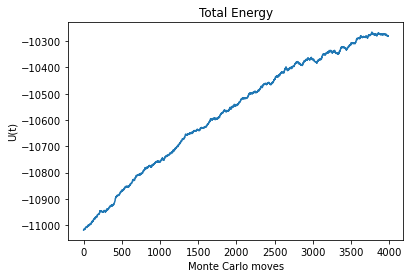

In [ ]:
plt.figure()
plt.plot(range(len(Ut)), Utcolor='black', label='Total energy')
plt.xlabel('Accepted moves in Monte Carlo (NVT)', fontsize=15)
plt.ylabel('Total Energy',fontsize=15)
plt.xticks(fontsize=15)
plt.legend()
plt.yticks(fontsize=15)

plt.show()